# An autoencoder on digits

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import time

In [2]:
#Converting data to torch.FloatTensor
torch.manual_seed(1)
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50, num_workers=0)

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

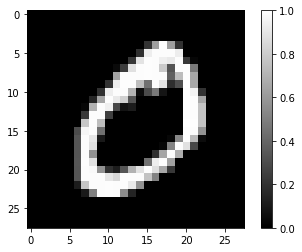

In [8]:
plt.imshow(images[1][0, :, :], cmap='gray')
plt.colorbar()

In [9]:
class AutoencoderCNN(nn.Module):
    def __init__(self, dim=10):
        super(AutoencoderCNN, self).__init__()
        self.dim = dim
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv1_relu = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.conv2_relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.latentdown = nn.Linear(784, dim)
        self.latentdown_relu = nn.ReLU()
        self.latentup = nn.Linear(dim, 784)
        self.latentup_relu = nn.ReLU()
        self.reshape = nn.Unflatten(1, (16, 7, 7))
        self.conv2up = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1)
        self.conv2up_relu = nn.ReLU()
        self.conv1up = nn.ConvTranspose2d(8, 1, 3, stride=2, output_padding=1)
        self.conv1up_relu = nn.ReLU()
    
    def forward(self, x):
        layers = [self.conv1, self.conv1_relu, self.conv2, self.conv2_relu]
        layers += [self.flatten, self.latentdown, self.latentdown_relu]
        layers += [self.latentup, self.latentup_relu, self.reshape]
        layers += [self.conv2up, self.conv2up_relu, self.conv1up, self.conv1up_relu]
        y = x
        for layer in layers:
            y = layer(y)
        return y
    
    def project_latent(self, x):
        layers = [self.conv1, self.conv1_relu, self.conv2, self.conv2_relu]
        layers += [self.flatten, self.latentdown, self.latentdown_relu]
        y = x
        for layer in layers:
            y = layer(y)
        return y

class AutoencoderCNNDeeper(nn.Module):
    def __init__(self, dim=10):
        super(AutoencoderCNNDeeper, self).__init__()
        self.dim = dim
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1) # 32 x 14 x 14
        self.conv1_relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # 64 x 7 x 7
        self.conv2_relu = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2) # 128 x 3 x 3
        self.conv3_relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.latentdown = nn.Linear(1152, dim)
        self.latentdown_relu = nn.ReLU()
        self.latentup = nn.Linear(dim, 1152)
        self.latentup_relu = nn.ReLU()
        self.reshape = nn.Unflatten(1, (128, 3, 3))
        self.conv3up = nn.ConvTranspose2d(128, 64, 3, stride=2)
        self.conv3up_relu = nn.ReLU()
        self.conv2up = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv2up_relu = nn.ReLU()
        self.conv1up = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)
        self.conv1up_relu = nn.ReLU()
    
    def forward(self, x):
        layers = [self.conv1, self.conv1_relu, self.conv2, self.conv2_relu, self.conv3, self.conv3_relu]
        layers += [self.flatten, self.latentdown, self.latentdown_relu]
        layers += [self.latentup, self.latentup_relu, self.reshape]
        layers += [self.conv3up, self.conv3up_relu, self.conv2up, self.conv2up_relu, self.conv1up, self.conv1up_relu]
        y = x
        for layer in layers:
            y = layer(y)
        return y
    
    def project_latent(self, x):
        layers = [self.conv1, self.conv1_relu, self.conv2, self.conv2_relu, self.conv3, self.conv3_relu]
        layers += [self.flatten, self.latentdown, self.latentdown_relu]
        y = x
        for layer in layers:
            y = layer(y)
        return y
    
model = AutoencoderCNNDeeper(2)
res = model(images)
print(res[0].shape)

torch.Size([1, 28, 28])


In [10]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


AutoencoderCNNDeeper(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv1_relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2_relu): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (conv3_relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (latentdown): Linear(in_features=1152, out_features=2, bias=True)
  (latentdown_relu): ReLU()
  (latentup): Linear(in_features=2, out_features=1152, bias=True)
  (latentup_relu): ReLU()
  (reshape): Unflatten(dim=1, unflattened_size=(128, 3, 3))
  (conv3up): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3up_relu): ReLU()
  (conv2up): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv2up_relu): ReLU()
  (conv1up): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv1up_relu): ReLU()
)

In [11]:
for data in test_loader:
    break
test_data = data[0]
test_data = test_data.to(device)
K=10
def test_model(model):
    res = model(test_data)
    orig = test_data
    if not device == "cpu":
        orig = orig.cpu()
        res = res.cpu()
    orig = orig.detach().numpy()
    res = res.detach().numpy()
    for k in range(K*int(K/2)):
        plt.subplot(K, 2*int(K/2), 2*k+1)
        plt.imshow(orig[k, 0, :, :], cmap='gray')
        plt.axis("off")
        if k < int(K/2):
            plt.title("Original")
        plt.subplot(K, 2*int(K/2), 2*k+2)
        plt.imshow(res[k, 0, :, :], cmap='gray')
        plt.axis("off")
        if k < int(K/2):
            plt.title("Reconstructed")

1.621,1.424,1.349,1.312,1.288,1.271,1.257,1.247,1.237,1.232,1.223,1.218,1.213,1.207,1.205,1.200,1.196,1.192,1.190,1.186,1.183,1.182,1.178,1.176,1.175,1.173,1.170,1.169,1.167,1.165,1.163,1.164,1.161,1.160,1.158,1.157,1.155,1.154,1.154,1.152,

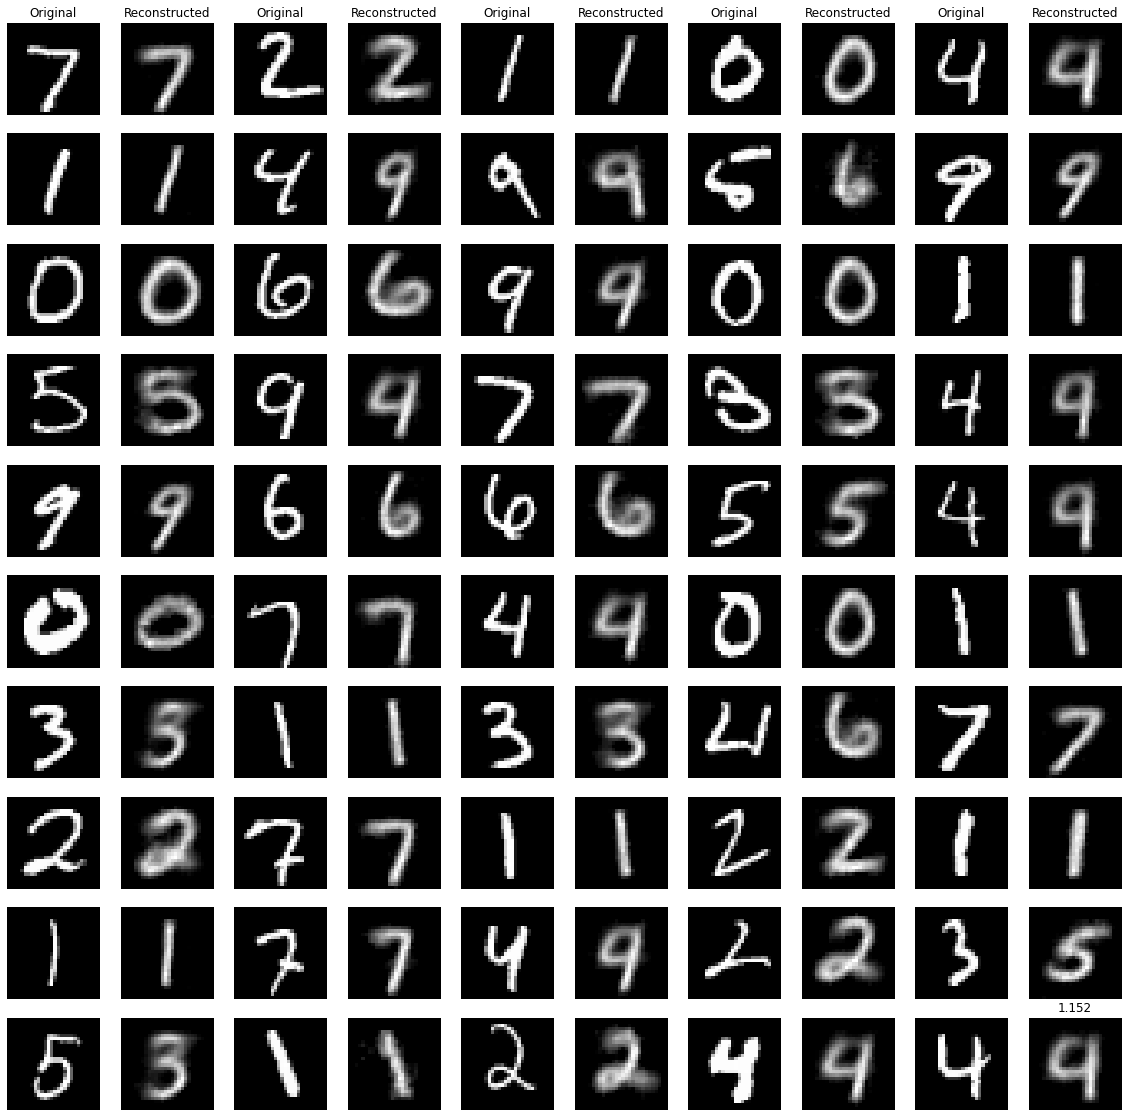

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
plt.figure(figsize=(K*2, K*2))

n_epochs = 40
losses = []
for epoch in range(n_epochs):
    tic = time.time()
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss /= len(train_loader)
    losses.append(train_loss)
    plt.clf()
    test_model(model)
    s = '{:.3f}'.format(train_loss)
    print(s, end=',')#, "\nElapsed Time={:.3f}".format(time.time()-tic))
    plt.title(s)
    plt.savefig("{}.png".format(epoch), bbox_inches='tight', facecolor='white')

Text(0.5, 0, 'Iteration')

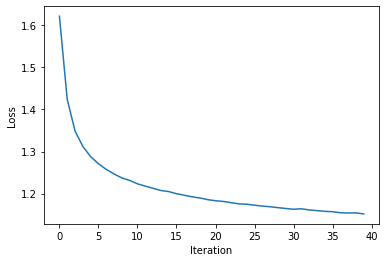

In [13]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Iteration")

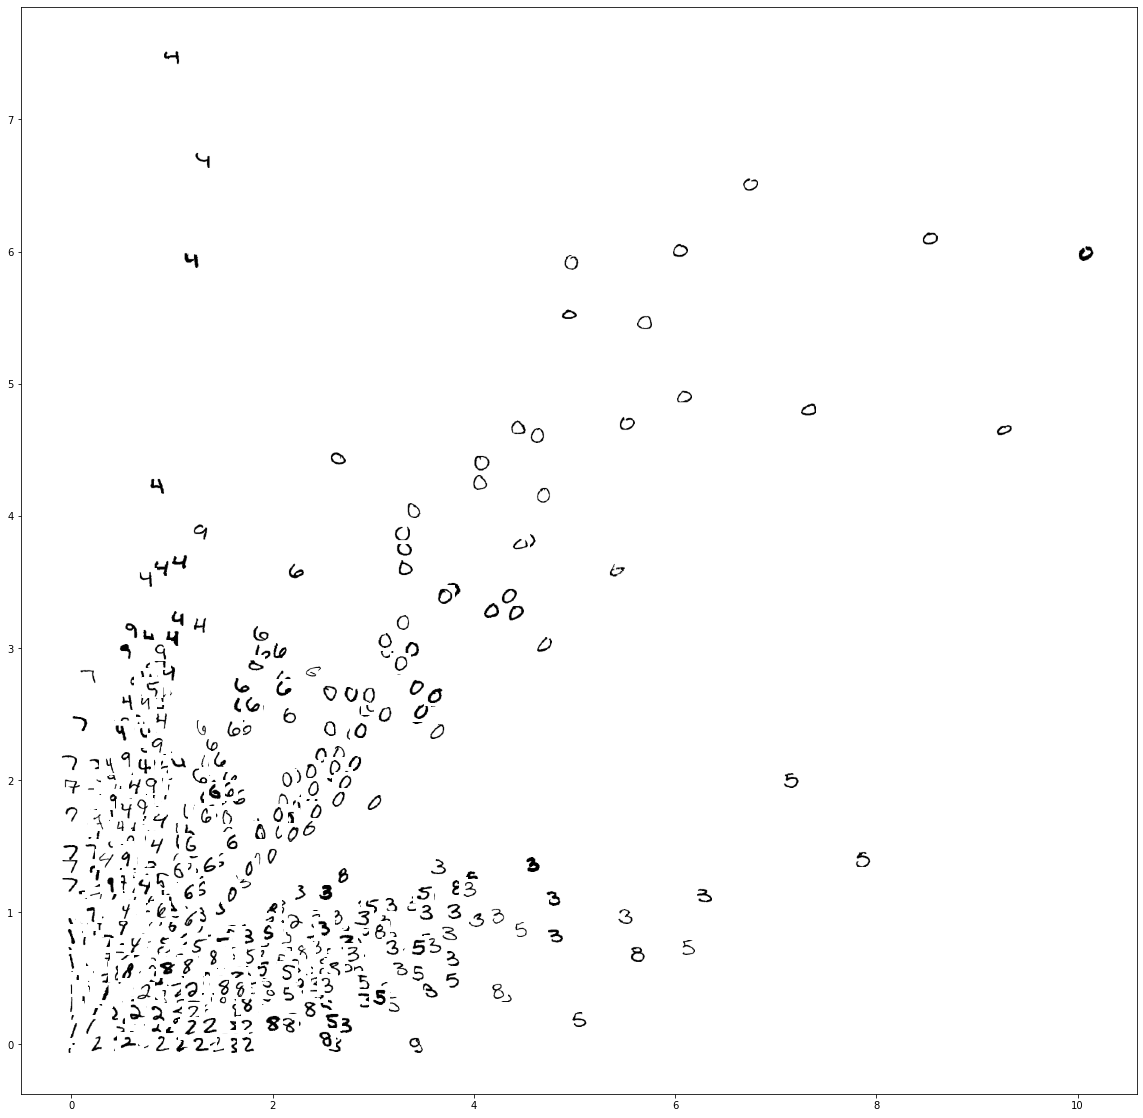

In [14]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Plot the first two coordinates of 1000 random encodings
n_digits = 1000 # Number of digits to shoot for
plt.figure(figsize=(20, 20))
ax = plt.gca()
encoded_imgs = np.array([])
for data in test_loader:
    data = data[0]
    data = data.to(device)
    
    res = model.project_latent(data)
    orig = data
    if not device == "cpu":
        orig = orig.cpu()
        res = res.cpu()
    orig = orig.detach().numpy()
    res = res.detach().numpy()
    for k in range(orig.shape[0]):
        x, y = res[k, :]
        img = orig[k, 0, :, :]
        img = OffsetImage(img, zoom=0.75, cmap='gray_r')
        ab = AnnotationBbox(img, (x, y), xycoords='data', frameon=False)
        ax.add_artist(ab)
    if encoded_imgs.size == 0:
        encoded_imgs = res
    else:
        encoded_imgs = np.concatenate((encoded_imgs, res), axis=0)
    if encoded_imgs.shape[0] > n_digits:
        break
ax.update_datalim(encoded_imgs)
ax.autoscale()